In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import lightkurve as lk
from scipy import stats
from photutils import centroids as cent
import scipy.optimize as opt
from tqdm import tqdm_notebook
import pandas as pd

In [2]:
def Simulate_Image(imageshape=(11,11),star1pos = [5,5],star1flux = 1000 , freq=10):

    time = np.arange(1000)*1./48.
    relamp = 1
    signal = relamp * np.sin(time*freq*2*np.pi)

    #Images
    seeingsigma = 1.

    imagestack = np.zeros((imageshape[0],imageshape[1],len(time)))
    xcoord,ycoord = np.meshgrid(np.arange(imageshape[1]),np.arange(imageshape[0])) #strange order



    backgroundnoise = 10.

    #add starlight
    distance1 = np.sqrt((xcoord-star1pos[0])**2 + (ycoord-star1pos[1])**2)

    for i in range(len(time)):
        #star 1
        imagestack[:,:,i] += stats.norm.pdf(distance1,scale=seeingsigma) * star1flux * (1. + signal[i])


        #add measurement noise
        #should probably be Poisson
        imagestack[:,:,i] += stats.norm.rvs(size=imagestack[:,:,i].size).reshape(imageshape) * np.sqrt(imagestack[:,:,i])

        #background
        #imagestack[:,:,i] += backgroundnoise
        imagestack[:,:,i] += stats.norm.rvs(size=imagestack[:,:,i].size).reshape(imageshape) * np.sqrt(backgroundnoise)
    stars = imagestack[:,:,:].T
    diction = {
        'stars':stars,
        'frequency':freq,
        'starposition':star1pos,
        'starflux':star1flux,
        'time':time,
        'imageshape':imageshape
    }
    return diction

In [3]:
def frequency_heatmap(pg,timeserieslength,frequency):
    heat_stamp = []
        
    for i in np.arange(0,len(pg)):
        for j in np.arange(0,len(pg[0])):
            mask = np.zeros((len(pg),len(pg[0])), dtype=bool)
            mask[i][j] = True
                
            period = pg[mask][0]
            normperiod = np.asarray(period.power)/np.nanmedian(np.asarray(period.power))
            freq = np.asarray(period.frequency)
            sums = 0 
            background = 0
            for k in np.arange(len(frequency)):
                sums += np.asarray(normperiod[np.where((freq < frequency[k]+(1/timeserieslength) ) & (freq > frequency[k]-(1/timeserieslength)))]).sum()
                background += len(np.where((freq < frequency[k]+(1/timeserieslength) ) & (freq > frequency[k]-(1/timeserieslength)))[0])
            heat_stamp.extend([sums-background])
        
    heat_stamp = np.reshape(np.asarray(heat_stamp),(len(pg),len(pg[0])))
    return heat_stamp

In [5]:
def tdg_fit(heatmap_data):
    
    def two_dGaussian( shape , amplitude, xo, yo, sigma, offset):
        x,y = np.meshgrid(shape[0],shape[1])
        xo = float(xo)
        yo = float(yo)    
        b = 1/(2*sigma**2)
        g = offset + amplitude*np.exp( - (b*((x-xo)**2) + b*((y-yo)**2)))
        return g.flatten()
    
    c = cent.centroid_2dg(heatmap_data)
    x = np.arange(0,np.shape(heatmap_data)[0])
    y = np.arange(0,np.shape(heatmap_data)[1])

    initial_guess = (heatmap_data.max(),c[0],c[1],1,np.nanmedian(heatmap_data))
    popt, pcov = opt.curve_fit(two_dGaussian, (x,y),heatmap_data.flatten(), p0=initial_guess)
    
    return popt,np.sqrt(np.diagonal(pcov))

In [6]:
def Create_LightCurve(*simulatedimage):
    imageshape = simulatedimage[0]['imageshape']
    time = simulatedimage[0]['time']
    lc_array = np.zeros(imageshape,dtype=object)
    fluxtype = simulatedimage[0]['stars']
    for i in np.arange(0,imageshape[0]):
        for j in np.arange(0,imageshape[1]):
            lc_array[j][i] = lk.LightCurve(time = time, flux = fluxtype.T[i,j,:])
    return lc_array

In [9]:
def Create_Periodogram(lc):
    pg = np.zeros(shape = (len(lc[0]),len(lc[1])),dtype=object)
    for i in np.arange(0,len(lc[0])):
        for j in np.arange(0,len(lc[1])):
            pg[i][j] = lc[i][j].to_periodogram()
    return pg

In [12]:
fits = []
covariance = []
for i in tqdm_notebook(np.arange(0,1000)):
    image = Simulate_Image(imageshape=(11,11),star1pos=[5,5])
    lc = Create_LightCurve(image)
    pg = Create_Periodogram(lc)
    fhp = frequency_heatmap(pg,48/999,[10])
    loc = tdg_fit(fhp)
    fits.extend([loc[0]])
    covariance.extend([loc[1]])

In [24]:

x_values = np.asarray(fits)[:,1]

In [37]:
y_values = np.asarray(fits)[:,2]

In [25]:
x_err = np.asarray(covariance)[:,1]

In [26]:
y_err = np.asarray(covariance)[:,2]

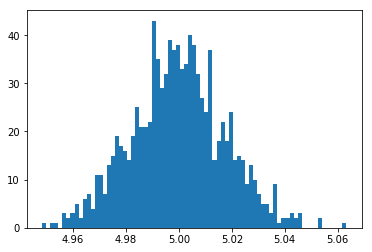

In [33]:
plt.hist(x_values,bins=75);

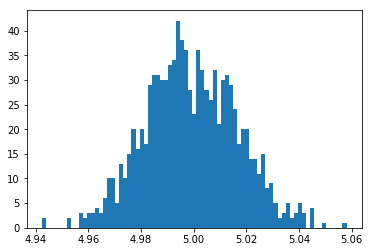

In [38]:
plt.hist(y_values,bins=75);

In [41]:
np.std(np.sqrt(np.square(5-x_values)+np.square(5-y_values)))

0.01138664723267301

In [42]:
np.mean(np.sqrt(np.square(x_err)+np.square(y_err)))

0.022036297366638324

In [44]:
data_frame =  pd.DataFrame({'x values': x_values,
                            'y values': y_values,
                            'x std. from fit': x_err,
                            'y std. from fit': y_err})

In [47]:
data_frame.to_csv('1000simulatedfits.csv')

pixelmapperiodogram <class> takes tpf, and periodogram info
    self.pg 
        "2d-array of periodograms"
    self.timeserieslength
    
    
    funct plot()
        plots frequency power specturm of periodogram for each pixel
    funct gaia_data()
        sets self.gaiadata
        
    funct to_heatmap([frequencylist]) returns class
        
Frequency heatmap <class> takes pixelmapperiodogram, and frequencylist
    self.frequencyheatmap 
        2d array of integrated frequency power spectrums


    funct centroid(self)
        sets self.x, self.y, self.cov

    funct closeststar(self)
        sets self.closeststar 


iter tools
